In [1]:
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video
import scienceplots
plt.style.use(['science', 'grid'])

# Add src to path
sys.path.append(str(Path(os.getcwd()).parent / "src"))

from phd.utils import ResultsManager
from phd.models.cm.analytical_plate import (
    train, exact_solution, plot_results, load_run, 
    animate, subsample_frames, update_frame, save_run_data
)

Using backend: jax
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



## Forward Problem
We train the model to solve the linear elasticity PDE given boundary conditions.

In [3]:
# Configure and Train Forward Model
config_forward = {
    "task": "forward",
    "n_iter": 50000, # Short run for demonstration
    "log_every": 200,
    "generate_video": False, # We will generate it manually
    "save_on_disk": False, # Save on disk using timestamp for run directory
    "results_dir": "analytical_plate_results",
    "net_type": "SPINN",
    "lr_decay": ["warmup cosine", 1e-5, 1e-3, 1000, 50000, 1e-5],
}

run_name = "forward_SPINN" # fixed name for saving/loading

train_model = True
save_run = True
if train_model:
    print("Training Forward Model...")
    results_forward = train(config_forward)
    if save_run:
        print("Saving run data in directory:", run_name)
        results_forward["run_dir"] = Path(config_forward["results_dir"]) / run_name
        save_run_data(results_forward)
else:
    run_dir_forward = Path(config_forward["results_dir"]) / run_name
    print(f"Loading existing results from {run_dir_forward}...")
    results_forward = load_run(run_dir_forward)

Training Forward Model...
Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.052468 s

Training model...

0         [1.78e+03, 2.62e+02, 2.80e-05, 3.25e+01, 4.83e-04]    [1.78e+03, 2.61e+02, 2.86e-05, 3.30e+01, 4.78e-04]    [1.14e+00]    
200       [1.59e+03, 2.05e+02, 1.56e+00, 1.02e+01, 1.01e+01]    [1.59e+03, 2.04e+02, 1.59e+00, 1.03e+01, 9.71e+00]    [1.14e+00]    
400       [3.90e+02, 8.84e+01, 1.58e+01, 4.78e+00, 9.16e+00]    [3.68e+02, 8.29e+01, 1.60e+01, 4.43e+00, 8.78e+00]    [6.38e-01]    
600       [3.38e+02, 7.12e+01, 7.71e+00, 2.72e+00, 5.79e+00]    [3.17e+02, 6.62e+01, 7.15e+00, 2.57e+00, 5.59e+00]    [6.31e-01]    
800       [7.88e+01, 1.34e+01, 3.98e+00, 6.29e+00, 9.75e+00]    [7.22e+01, 1.26e+01, 3.85e+00, 6.08e+00, 9.62e+00]    [7.09e-01]    
1000      [6.50e+00, 2.85e+00, 9.72e-01, 1.07e+00, 4.90e-01]    [5.43e+00, 2.54e+00, 8.64e-01, 9.74e-01, 4.92e-01]    [2.00e-01]    
1200      [4.79e+00, 1.64e+00, 5.43e-01, 3.48e-01, 2

### Forward Results Visualization
We generate the animation manually here to visualize the training progress.

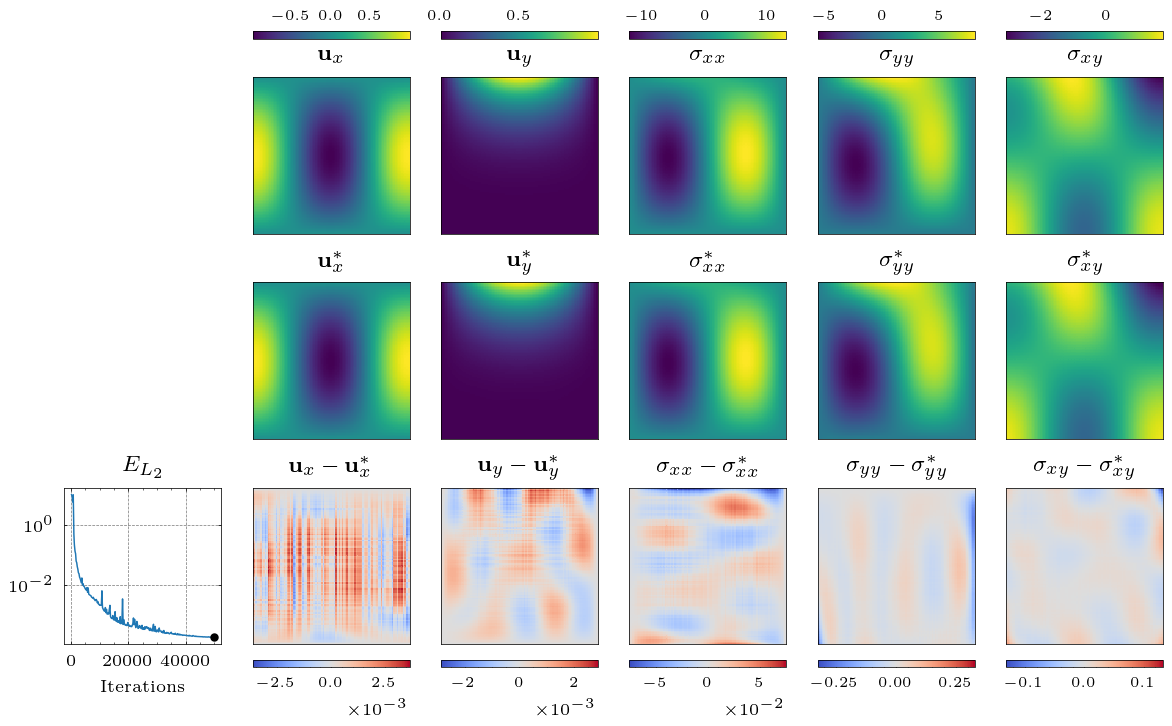

In [4]:
from ipywidgets import interact, IntSlider



fig, artists = plot_results(results_forward, iteration=-1, dpi=200)

# Uncomment to enable interactive plotting
# n_steps = len(results_forward["field_saver"].history)
# @interact(frame_iter=IntSlider(min=0, max=n_steps-1, step=1, value=n_steps-1))
# def plot_interactive(frame_iter):
#     fig, artists = plot_results(results_forward, iteration=frame_iter, dpi=200)
#     plt.show()

Subsampled from 200 to 123 frames
Animation preview:
  Total available frames: 200
  Selected frames: 123
  FPS: 10
  Duration: 12.3s


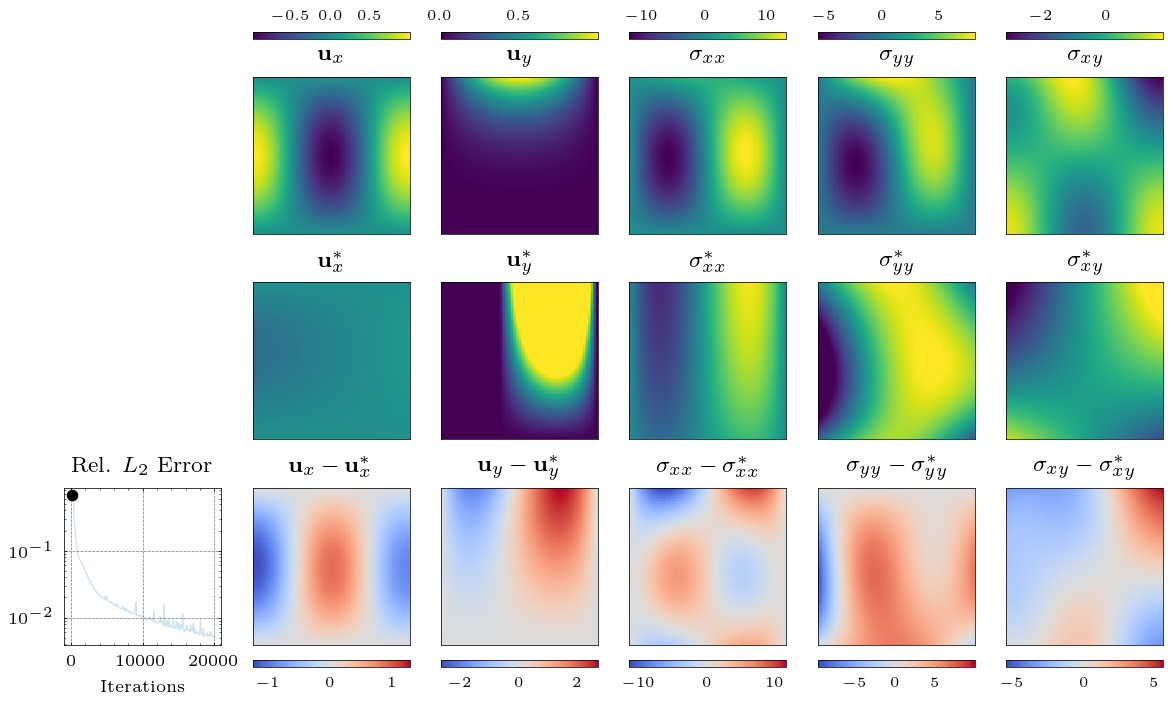

In [4]:
# Generate Animation
run_dir_forward = results_forward["run_dir"]
video_path_forward = Path(run_dir_forward) / "training_animation.mp4"

# Create figure and artists
fig, artists = plot_results(results_forward, iteration=0, dpi=200)

# Preview animation with custom frame subsampling (more frames at beginning)
n_frames = len(artists["steps"])
frame_indices = subsample_frames(n_frames, factors=[1,2,3])  # Dense start, sparse end
print(f"Subsampled from {n_frames} to {len(frame_indices)} frames")

# Preview duration before saving
animate(fig, artists, video_path_forward, fps=10, frame_indices=frame_indices, preview=True)

# Uncomment to actually save:
# animate(fig, artists, video_path_forward, fps=10, frame_indices=frame_indices)
# Display Training Animation
# Video(video_path_forward, embed=True, html_attributes="controls loop autoplay")

In [ ]:
# Save Run Data
from phd.models.cm.analytical_plate import save_run_data
print("Saving run data to disk...")
save_run_data(results_forward)
print(f"Data saved to {run_dir_forward}")

### Workflow Flexibility
The workflow demonstrated above allows for flexible experimentation:
1. **Train**: Run the training loop with `save_fields_to_disk=False` to keep data in memory.
2. **Visualize**: Inspect results immediately using `plot_results` or `create_animation`.
3. **Save**: If the run is successful, persist the data using `save_run_data`.

This can all be controlled via the configuration dictionary passed to `train()`.

## Inverse Problem
We train the model to discover material parameters ($\lambda, \mu$) from synthetic data.

In [2]:
# Configure and Train Inverse Model
n_iter = 75000
config_inverse = {
    "task": "inverse",
    "n_iter": n_iter,
    "log_every": 250,
    "generate_video": False, # Automatic generation disabled
    "save_on_disk": False, # Save on disk using timestamp for run directory
    "results_dir": "analytical_plate_results",
    "net_type": "SPINN",
    "lmbd_init": 2.0, # Initial guess
    "mu_init": 0.3,   # Initial guess
    "lmbd": 1.0,      # Target
    "mu": 0.5,        # Target
    "n_DIC": 10,       # Number of DIC points (10x10)
    "lr_decay": ["warmup cosine", 1e-5, 1e-3, 1000, n_iter, 1e-5]
}
run_name = "inverse_SPINN" # fixed name for saving/loading

train_model = True
save_run = True
if train_model:
    print("Training Inverse Model...")
    results_inverse = train(config_inverse)
    if save_run:
        results_inverse["run_dir"] = Path(config_inverse["results_dir"]) / run_name
        save_run_data(results_inverse)
else:
    run_dir_inverse = Path(config_inverse["results_dir"]) / run_name
    results_inverse = load_run(run_dir_inverse)
        

Training Inverse Model...
Set the default automatic differentiation to forward mode.


W1127 14:06:06.508120  627058 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1127 14:06:06.512052  626730 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


Compiling model...
'compile' took 2.264698 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric   
0         [1.78e+03, 2.62e+02, 2.96e-05, 3.25e+01, 4.87e-04, 2.47e-01, 7.10e-02]    [1.78e+03, 2.61e+02, 3.01e-05, 3.30e+01, 4.82e-04, 2.47e-01, 7.10e-02]    [1.13e+00]    
250       [9.92e+02, 1.53e+02, 6.34e-01, 7.94e+00, 1.09e+01, 2.58e-01, 6.26e-01]    [9.97e+02, 1.52e+02, 6.30e-01, 7.61e+00, 1.05e+01, 2.58e-01, 6.26e-01]    [1.15e+00]    
500       [3.64e+02, 8.06e+01, 6.35e+00, 4.39e+00, 3.62e+00, 1.84e-01, 4.83e-01]    [3.42e+02, 7.50e+01, 6.20e+00, 4.29e+00, 3.50e+00, 1.84e-01, 4.83e-01]    [6.88e-01]    
750       [1.79e+02, 1.39e+01, 4.82e+00, 4.86e+00, 8.10e+00, 1.04e-01, 5.78e-01]    [1.67e+02, 1.30e+01, 4.67e+00, 4.77e+00, 7.99e+00, 1.04e-01, 5.78e-01]    [8.36e-01]    
1000      [8.24e+00, 3.20e+00, 1.61e+00, 1.26e+00, 5.77e-01, 3.66e-02,

### Inverse Results Visualization

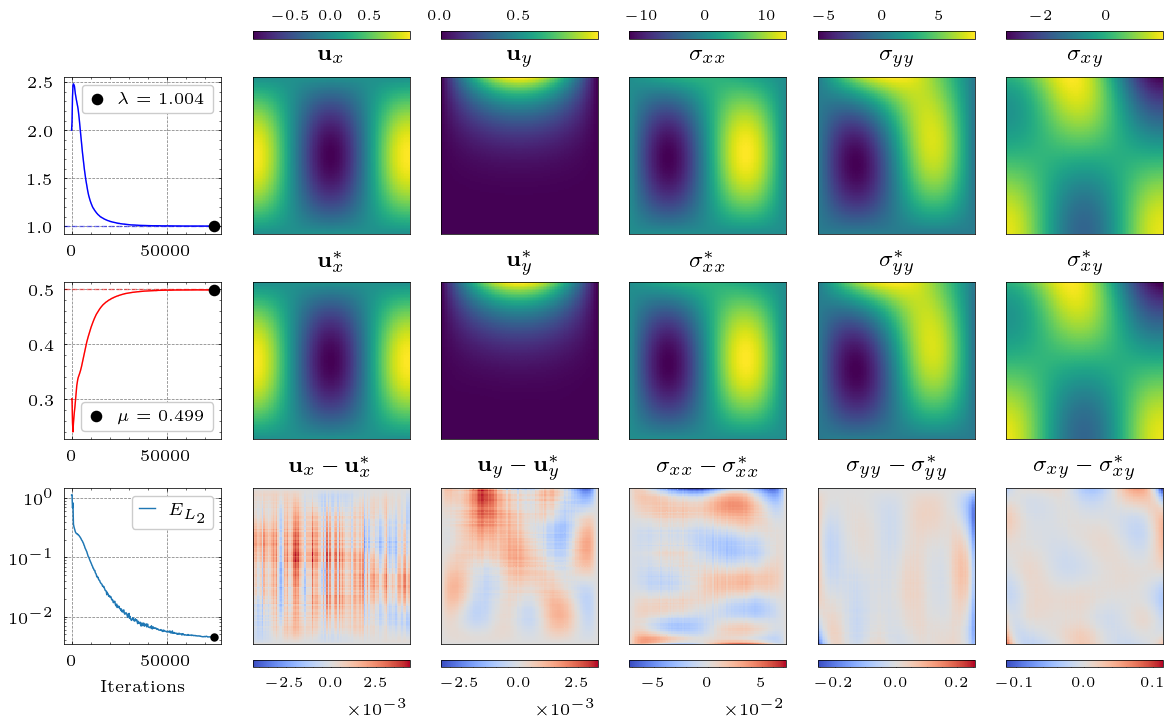

In [3]:
# Create figure and artists
step = len(results_inverse["losshistory"].steps)-2
fig_inv, artists_inv = plot_results(results_inverse, iteration=step, dpi=200)

In [6]:
# Generate Animation for Inverse Problem
video_path_inverse = results_inverse["run_dir"] / "training_animation.mp4"
print("Generating animation...")

# Custom frame subsampling - more detail at the beginning
n_frames = len(artists_inv["steps"])
frame_indices = subsample_frames(n_frames, factors=[1, 1, 2, 3])

# Preview
animate(fig_inv, artists_inv, video_path_inverse, fps=10, frame_indices=frame_indices, preview=True)

# Save
fig_inv, artists_inv = plot_results(results_inverse, iteration=0)
animate(fig_inv, artists_inv, video_path_inverse, fps=10, frame_indices=frame_indices)

Generating animation...
Animation preview:
  Total available frames: 30
  Selected frames: 22
  FPS: 10
  Duration: 2.2s
Animation saved to analytical_plate_results/inverse_SPINN/training_animation.mp4 (22 frames, 2.2s)


In [7]:
# Display Inverse Training Animation
Video(video_path_inverse, embed=True, html_attributes="controls loop autoplay")

In [ ]:
# Save Inverse Run Data
print("Saving inverse run data to disk...")
save_run_data(results_inverse)
print(f"Data saved to {run_dir_inverse}")

In [4]:
# Static Plot of Parameter Evolution
# We can load from disk now that we saved it, or use the results dict directly
data_inverse = load_run(run_dir_inverse)
cb = data_inverse["variable_value_callback"]

if cb and cb.history:
    vars_hist_arr = np.array(cb.history)
    vars_steps = vars_hist_arr[:, 0]
    vars_values = vars_hist_arr[:, 1:]  # lambda, mu
else:
    vars_steps = []
    vars_values = np.zeros((0, 2))

plt.figure(figsize=(2, 1.5), dpi=300) 
plt.plot(vars_steps, vars_values[:, 0], label=r"$\lambda$ (Pred)")
plt.axhline(config_inverse["lmbd"], color='b', linestyle='--', label=r"$\lambda$ (True)")
plt.plot(vars_steps, vars_values[:, 1], label=r"$\mu$ (Pred)")
plt.axhline(config_inverse["mu"], color='orange', linestyle='--', label=r"$\mu$ (True)")
plt.legend()
plt.title("Parameter Discovery Evolution")
plt.xlabel("Steps")
plt.ylabel("Value")
plt.grid(True, alpha=0.3)
plt.show()

NameError: name 'run_dir_inverse' is not defined